# Predicting Housing Prices (Continued)

## Lilit Petrosyan

In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Data

As a reminder, the [Ames dataset](http://jse.amstat.org/v19n3/decock.pdf) consists of 2930 records taken from the Ames, Iowa, Assessor’s Office describing houses sold in Ames from 2006 to 2010.  The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total.  An explanation of each variable can be found in the included `codebook.txt` file.  The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010.

The raw data are split into training and test sets with 2000 and 930 observations, respectively. To save some time, we've used a slightly modified data cleaning pipeline from last week's assignment to prepare the training data. This data is stored in `ames_train_cleaned.csv`.

In [3]:
training_data = pd.read_csv("ames_train_cleaned.csv")

# Part IV: More Feature Selection and Engineering

In this section, we identify two more features of the dataset that will increase our linear regression model's accuracy. Additionally, we will implement one-hot encoding so that we can include binary and categorical variables in our improved model.

## Question 1: Neighborhood vs Sale Price

First, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set.

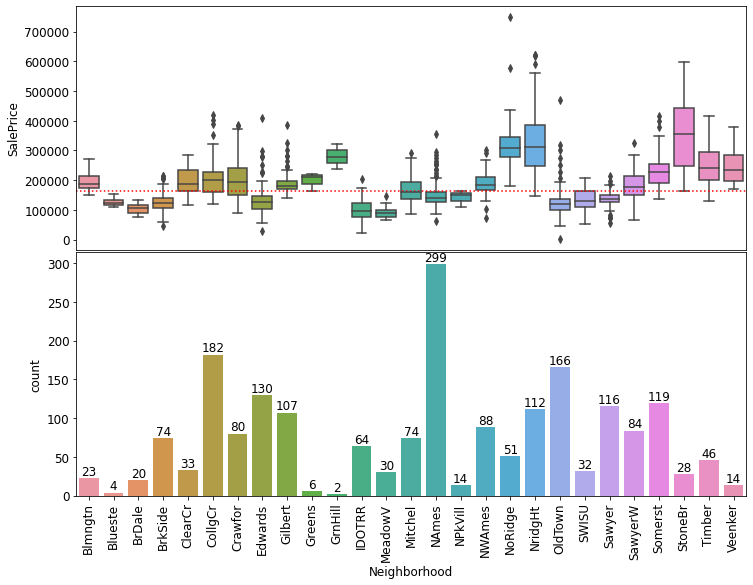

In [4]:
fig, axs = plt.subplots(nrows=2)
sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)
sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)
# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)
# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)
# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

### Question 1a <a name="q1b"></a> 

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `SalePrice` and identify them as "rich neighborhoods"; the other neighborhoods are not marked.

Write a function that returns list of the top n most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_rich_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `SalePrice`.


In [5]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = list(
        data
        .groupby('Neighborhood')['SalePrice']
        .aggregate(metric)
        .sort_values(ascending=False)
        .head(n)
        .index.values
    )
    return neighborhoods
rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']

### Question 1c <a name="q1c"></a> 

We now have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`.  Write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` and the value 0 otherwise.


In [6]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data['in_rich_neighborhood'] = ...
    data['in_rich_neighborhood'] = data['Neighborhood'].isin(neighborhoods).astype('int32') # SOLUTION NO PROMPT
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

## Question 2: Fireplace Quality

In the following question, we will take a closer look at the Fireplace_Qu feature of the dataset and examine how we can incorporate categorical features into our linear model.

### Question 2a <a name="q2a"></a>

Let's see if our data set has any missing values.  Create a Series object containing the counts of missing values in each of the columns of our data set, sorted from greatest to least.  The Series should be indexed by the variable names.  For example, `missing_counts['Fireplace_Qu']` should return 975.


In [7]:
missing_counts = training_data.isnull().sum().sort_values(ascending=False) # SOLUTION
missing_counts

Pool_QC            1991
Misc_Feature       1922
Alley              1865
Fence              1607
Fireplace_Qu        975
                   ... 
Low_Qual_Fin_SF       0
2nd_Flr_SF            0
1st_Flr_SF            0
Central_Air           0
Order                 0
Length: 84, dtype: int64

It turns out that if we look at the codebook carefully, some of these "missing values" aren't missing at all! The Assessor's Office just used `NA` to denote a special value or that the information was truly not applicable for one reason or another.  One such example is the `Fireplace_Qu` variable.
```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```

 ### Question 2b <a name="q2b"></a>

An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  Write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  In addition, it should replace each abbreviated condition with its full word.  For example, `'TA'` should be changed to `'Average'`.  Hint: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.


In [8]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    replacements = {
        'Fireplace_Qu': {
            'Ex': 'Excellent',
            'Gd': 'Good',
            'TA': 'Average',
            'Fa': 'Fair',
            'Po': 'Poor',
            np.nan: 'No Fireplace'
        }
    }
    
    data = data.replace(replacements)
    return data
    
training_data = fix_fireplace_qu(training_data)

### An Important Note on One Hot Encoding <a name="important_note"></a>

Unfortunately, simply fixing these missing values isn't sufficient for using `Fireplace_Qu` in our model.  Since `Fireplace_Qu` is a categorical variable, we will have to one-hot-encode the data.  Notice in the example code below that we have to pre-specify the categories.  Why? Imagine what would happen if we automatically generated the categories only from the training data.  What would happen if the testing data contained a category not found in the training set?

In [9]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        'No Fireplace'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data.loc[:, 'Fireplace_Qu'] = data.loc[:, 'Fireplace_Qu'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fpq',
                          columns=['Fireplace_Qu'], 
                          drop_first=True)
    
    return data

In [10]:
training_data = ohe_fireplace_qu(training_data)
training_data.filter(regex='fpq').head(10)

,fpq_Good,fpq_Average,fpq_Fair,fpq_Poor,fpq_No Fireplace
0,1,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0
5,1,0,0,0,0
6,0,0,0,0,1
7,0,1,0,0,0
8,0,0,0,0,1
9,1,0,0,0,0


# Part V: Improved Linear Models

In this section, we will create linear models that produce more accurate estimates of the housing prices in Ames than the model created in Homework 5, but at the expense of increased complexity.

## Question 3: Adding Covariates to our Model

It's finally time to fit our updated linear regression model using the ordinary least squares estimator! Our new model consists of the linear model from Homework 5, with the addition of the our newly created `in_rich_neighborhood` variable and our one-hot-encoded fireplace quality variables:

$$\begin{align}
\text{SalePrice} & = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + 
\theta_3 \cdot \text{TotalBathrooms} + \theta_4 \cdot \text{in_rich_neighborhood} + \\
& \quad \: \theta_5 \cdot \text{fpq_Good} + \theta_6 \cdot \text{fpq_Average} + \theta_7 \cdot \text{fpq_Fair} +
\theta_8 \cdot \text{fpq_Poor} + \theta_9 \cdot \text{fpq_No_Fireplace}
\end{align}$$

### Question 3a 

We still have a little bit of work to do prior to esimating our linear regression model's coefficients. Instead of having you go through the process of splitting our data into training and testing sets, selecting the pertinent convariates and creating a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for our linear model again, we provide the necessary code from Homework 5.

In [11]:
training_data = pd.read_csv("ames_train_cleaned.csv")

# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general
np.random.seed(1337)
training_data_len = len(training_data)
shuffled_indices = np.random.permutation(training_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
train_indices = shuffled_indices[:int(training_data_len * 0.8)]
test_indices = shuffled_indices[int(training_data_len * 0.8):]

# Create train and test` by indexing into `full_data` using 
# `train_indices` and `test_indices`
train = training_data.iloc[train_indices]
test = training_data.iloc[test_indices]

Next, we will implement a reusable pipeline that selects the required variables in our data and splits our covariates and response variable into a matrix and a vector, respectively.

In [12]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]
def process_data_gm(data):
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'fpq_Good',
                          'fpq_Average',
                          'fpq_Fair',
                          'fpq_Poor',
                          'fpq_No Fireplace',
                         )
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']    
    return X, y

We then split our dataset into training and testing sets using our data cleaning pipeline.

In [13]:
X_train, y_train = process_data_gm(train)
X_test, y_test = process_data_gm(test)
train.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms
1504,2229,909475050,20,RL,NaN,20693,Pave,NaN,IR1,Bnk,...,NaN,GdWo,NaN,0,2,2007,WD,Normal,191400,2.0
1589,2349,527355060,60,RL,81.0,10530,Pave,NaN,Reg,Lvl,...,NaN,GdPrv,NaN,0,7,2006,WD,Normal,182900,2.5
1617,2392,528138030,60,RL,85.0,11924,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,7,2006,New,Partial,350900,4.0
835,1247,535302130,20,RL,102.0,9373,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2008,WD,Normal,145700,1.5
1704,2520,533253050,120,RL,36.0,3640,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,9,2006,WD,Normal,182100,2.0


Finally, we initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept.

In [14]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept=True)

After a little bit of work, it's finally time to fit our updated linear regression model. Use the cell below to estimate the model, and then use it to compute the fitted value of `SalePrice` over the training data and the predicted the values of `SalePrice` using the testing data. 

In [15]:
linear_model.fit(X_train, y_train)


y_fitted = linear_model.predict(X_train) 
y_predicted = linear_model.predict(X_test)

### Question 3b 

Let's assess the performance of our new linear regression model using the Root Mean Squared Error function that we created in Homework 5.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{# of houses}}}$$


In [16]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

Now use your `rmse` function to calculate the training error and test error in the cell below.

In [17]:
training_error = rmse(y_fitted, y_train) 
test_error = rmse(y_predicted, y_test)
print("Training RMSE: {}\nTest RMSE: {}".format(training_error, test_error))

Training RMSE: 40491.84911146645
Test RMSE: 38754.86068184426


# Part VI: Open-Response

The following part is purposefully left nearly open-ended.  The Ames data in your possession comes from a larger data set.  Your goal is to provide a linear regression model that accurately predicts the prices of the held-out homes, measured by root mean square error. 

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in public test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{# of houses}}}$$

Perfect prediction of house prices would have a score of 0, so you want your score to be as low as possible!

## Question 4: Your Own Linear Model <a name="q4"></a>

Just as in the guided model above, you should encapsulate as much of your workflow into functions as possible. Below, we have initialized `final_model` for you. Your job is to select better features and define your own feature engineering pipeline in `process_data_fm`. 

To evaluate your model, we will process training data using your `process_data_fm`, fit `final_model` with this training data, and compute the training RMSE. Then, we will process the test data with your `process_data_fm`, use `final_model` to predict sale prices for the test data, and compute the test RMSE. See below for an example of the code we will run to grade your model:

```
training_data = pd.read_csv('ames_train_cleaned.csv')
test_data = pd.read_csv('ames_test_cleaned.csv')

X_train, y_train = process_data_fm(training_data)
X_test, y_test = process_data_fm(test_data)

final_model.fit(X_train, y_train)
y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

training_rmse = rmse(y_predicted_train, y_train)
test_rmse = rmse(y_predicted_test, y_test)
```

In [18]:
final_model = lm.LinearRegression(fit_intercept=True)

def process_data_fm(data):
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'in_rich_neighborhood',
                          'Lot_Area',
                          'Year_Built',
                          'Fireplaces',
                          'Overall_Qual'
                         )
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    X = X.fillna(0)
    X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 0.00001)
    return X, y